In [9]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="0";  

# import tensorflow as tf
# import keras
# from keras.layers import Dense, Flatten
# from keras.layers import MaxPooling2D, Dropout, Conv2D, Activation
import numpy as np
import numpy.random as random
import pylab as plt
# from keras.datasets import mnist, cifar10
# from keras.preprocessing.image import ImageDataGenerator
# import keras.backend as K
# from sklearn import svm
import time
from datetime import datetime
import matplotlib

In [19]:
##
## Information Computations
##

# estimate I(M(x); y | L(x))
def estimate_IMYL(model, linModel, x, y):
    p = est_density(model, linModel, x, y)
    return I_XYZ(p)

def est_density_MYL(model, linModel, x, y):
    Mx = np.round(model.predict(x)).flatten()
    Lx = np.round(linModel.predict(x)).flatten()
    y = y.flatten()
    
    p = est_density(Mx, y, Lx)
    return p
    
def est_density(X, Y, Z): # estimate p[x,y,z] \in R^{{0,1}^3} for samples from X, Y, Z \in \N
    X = X.astype(int)
    Y = Y.astype(int)
    Z = Z.astype(int)
    
    n = len(X)
    p = np.zeros((2, 2, 2)) # p[x,y,z] is the joint prob density
    for i in range(n):
        p[X[i], Y[i], Z[i]] += 1.0
    p /= n
    return p

def I_XYZ(p): # compute I(X, Y | Z) for joint density p[x, y, z]
    pz = np.sum(p, axis=(0,1), keepdims=True) # the density of z. pz[x,y,z] = p(z)
    
    p_xy_z = p / pz  # q[x, y, z] = p(x, y | z)
    p_x_z =  np.sum(p, axis=1, keepdims=True) / pz  # p(x | z)
    p_y_z =  np.sum(p, axis=0, keepdims=True) / pz  # p(y | z)
    
    I = np.sum(p * np.nan_to_num(np.log2( p_xy_z / (p_x_z * p_y_z) )))
    return I


# returns I(A; B) where A, B \in {X, Y, Z} spefice by idx
# eg, I(X; Y) = I_ab(p, idx=[0, 1])
#     I(X; Z) = I_ab(p, idx=[0, 2])
def I_ab(p, idx=(0,1)): 
    exlude = (0+1+2) - np.sum(idx)
    p_ab = np.sum(p, axis=exlude)
    p_a = np.sum(p_ab, axis=1, keepdims=True)
    p_b = np.sum(p_ab, axis=0, keepdims=True)
    
    I = np.sum(p_ab * np.nan_to_num(np.log2( p_ab / (p_a * p_b) )))
    return I

def H(q): # binary entropy
    return -q*np.log2(q) - (1-q)*np.log2(1-q)


In [68]:
best_lin = np.fromfile('cifareasy1048/best_lin.npy')
I_MY_train = np.fromfile('cifareasy1048/I_MY_train.npy')
I_MY = np.fromfile('cifareasy1048/I_MY.npy')
mu = np.fromfile('cifareasy1048/mu.npy')

In [64]:
best_lin

array([0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589

In [65]:
print(best_lin.shape, I_MY_train.shape, I_MY.shape, mu.shape)

((300,), (1500,), (1500,), (1500,))


In [69]:
I_MY_train = I_MY_train.reshape(5, 300)
I_MY = I_MY.reshape(5, 300)
mu = mu.reshape(5, 300)

In [70]:
best_lin.shape

(300,)

<Figure size 7200x4800 with 0 Axes>

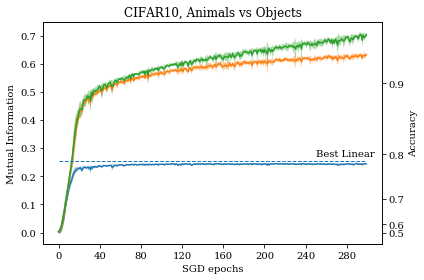

In [76]:
plt.rcParams["font.family"] = 'serif'
plt.figure(dpi=1200)
gap = mu
eps = len(gap[0])


lin_acc = best_lin[0]

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.4)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.4)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.4)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), lin_acc*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

plt.text(range(eps)[-50],  lin_acc+0.015, 'Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

# ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('CIFAR10, Animals vs Objects')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()
plt.savefig('cifareasy_plot2.pdf')

In [74]:
plt.clt()

AttributeError: 'module' object has no attribute 'clt'

In [60]:
best_lin = np.fromfile('mnist1104//best_lin.npy')
I_MY_train = np.fromfile('mnist1104/I_MY_train.npy').reshape(-1,50)
I_MY = np.fromfile('mnist1104/I_MY.npy').reshape(-1,50)
mu = np.fromfile('mnist1104/mu.npy').reshape(-1,50)

In [61]:
best_lin.shape

(50,)

<Figure size 7200x4800 with 0 Axes>

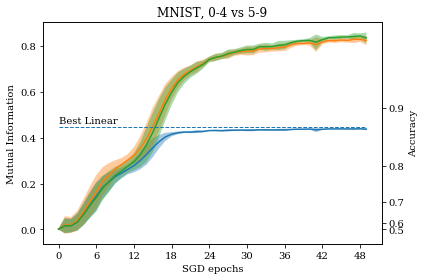

In [62]:
plt.rcParams["font.family"] = 'serif'
plt.figure(dpi=1200)
gap = mu
eps = len(gap[0])


lin_acc = best_lin[0]

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.4)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.4)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.4)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), lin_acc*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

plt.text(range(eps)[-50],  lin_acc+0.015, 'Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

# ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('MNIST, 0-4 vs 5-9')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()
plt.savefig('MNIST_plot.pdf')

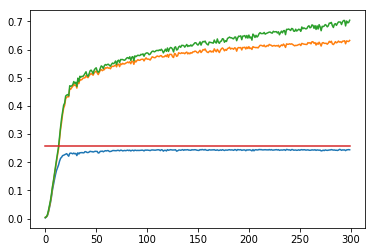

In [18]:
plt.plot(mu.mean(axis=0))
plt.plot(I_MY.mean(axis=0))
plt.plot(I_MY_train.mean(axis=0))
plt.plot(best_lin)

In [42]:
first_idx = np.where(I_MY.mean(axis=0) > best_lin)[0][0]

In [43]:
mu.mean(axis=0)[first_idx] / best_lin[0]

0.7957563344820199

In [44]:
mu.mean(axis=0)[-1] / I_MY.mean(axis=0)[-1]

0.38594861853872064

In [32]:
best_lin = np.fromfile('mnist1104//best_lin.npy')
I_MY_train = np.fromfile('mnist1104/I_MY_train.npy')
I_MY = np.fromfile('mnist1104/I_MY.npy')
mu = np.fromfile('mnist1104/mu.npy')

I_MY_train = I_MY_train.reshape(10, 50)
I_MY = I_MY.reshape(10, 50)
mu = mu.reshape(10, 50)

In [33]:
first_idx = np.where(I_MY.mean(axis=0) > best_lin)[0][0]

In [34]:
mu.mean(axis=0)[first_idx] / best_lin[0]

0.7932372584140739

In [37]:
mu.mean(axis=0)[-1] / I_MY.mean(axis=0)[-1]

0.530484637529362

In [4]:
from infotools import *
import pickle
(I_MY, I_MYL, I_MY_train, lin_accs) = pickle.load( open('../../data/cifar_hard_linear/cifar-hard-f30-300ep-b64-screenrun.p', 'rb' )) #  , encoding='latin1'
print(I_MY.shape)
print(len(lin_accs))
# compute best linear

(10, 300)
10


In [5]:
I_MY = I_MY[:, :100]
I_MYL = I_MYL[:, :100]
I_MY_train = I_MY_train[:, :100]

<Figure size 7200x4800 with 0 Axes>

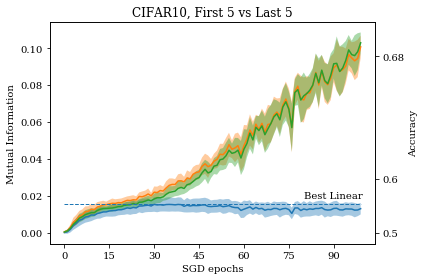

In [29]:
plt.rcParams["font.family"] = 'serif'
plt.figure(dpi=1200)
gap = I_MY - I_MYL
eps = len(gap[0])



fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.4)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.4)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.4)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(np.mean(lin_accs)))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

plt.text(range(eps)[-20],  (1-H(np.mean(lin_accs)))+0.003, 'Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

# ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.68, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('CIFAR10, First 5 vs Last 5')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()
plt.savefig('cifarhard_plot.pdf')

In [14]:
lin_acc

[0.5721, 0.5872, 0.5833, 0.572, 0.5724, 0.5778, 0.5443, 0.5781, 0.5767, 0.5648]